In [1]:
#  Import necessary libraries
import numpy as np
import pandas as pd
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn
from torch import optim

In [2]:
# Pima dataset

class PimaDataset(Dataset):

    def __init__(self, data):
        self.data = data
           
    def __getitem__(self, index):
        item = self.data.iloc[index].values    
        return (item[0:8].astype(np.float32), item[8].astype(np.int))

    def __len__(self):
        return self.data.shape[0]


    def get_datasets(pima_file, train_ratio=0.60,valid_ratio=0.20,test_ratio=0.20):

        
        df = pd.read_csv(pima_file)
        data=(df-df.mean())/df.std()

        train_df = data.sample(frac=train_ratio, random_state=5)
        validation_df = data.sample(frac=valid_ratio, random_state=5)
        test_df = data.sample(frac=test_ratio, random_state=5)

        return PimaDataset(train_df), PimaDataset(validation_df),PimaDataset(test_df)
    


In [3]:
pima_file = "diabetes.csv"

In [4]:
# Get train, validation and test data
train_ds,validation_ds,test_ds = PimaDataset.get_datasets(pima_file)

In [5]:
print('# instances in training set: ', len(train_ds))
print('# instances in validation set: ', len(validation_ds))
print('# instances in test set: ', len(test_ds))

# instances in training set:  461
# instances in validation set:  154
# instances in test set:  154


In [6]:
# load dataloader
batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

In [7]:
# create net
import torch.nn.functional as F
class PimaNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size,hidden2_size,num_classes):
        
        super(PimaNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)   
       
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    

In [8]:
net = PimaNet(8, 200,100, 2)
print(net)

PimaNet(
  (fc1): Linear(in_features=8, out_features=200, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


In [9]:
# set loss,learning rate and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-5)

In [10]:
# train the data and check for validation
num_epochs = 50

train_losses, valid_losses = [], []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (items, classes) in enumerate(train_loader):
    
        net.train()           

        optimizer.zero_grad() 
        outputs = net(items)  
        loss = criterion(outputs, classes) 
        loss.backward()       
        optimizer.step()      

        running_loss += loss.item()

    else:
        net.eval()
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            for i, (items, classes) in enumerate(validation_loader):
                outputs = net(items)
                loss = criterion(outputs,classes)
                valid_loss += loss.item()
                ps = torch.exp(outputs)
                
                top_p, top_class = ps.topk(1, dim=1)
                labels = classes.view(*top_class.shape)
                
                equals = top_class == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(validation_loader))
        print(f'Epoch: {epoch+1}/{num_epochs},Training loss:{sum(train_losses)/len(train_losses)},Validation loss: {sum(valid_losses)/len(valid_losses)},validation Accuracy: {accuracy/len(validation_loader)*100}%')


Epoch: 1/50,Training loss:0.6887051105499268,Validation loss: 0.6756080985069275,validation Accuracy: 63.5%
Epoch: 2/50,Training loss:0.6787048906087876,Validation loss: 0.6603421494364738,validation Accuracy: 77.0%
Epoch: 3/50,Training loss:0.6684571862220764,Validation loss: 0.6495331873496374,validation Accuracy: 72.25%
Epoch: 4/50,Training loss:0.6571444630622864,Validation loss: 0.6385990269482136,validation Accuracy: 72.25%
Epoch: 5/50,Training loss:0.6474307441711427,Validation loss: 0.6309816926717758,validation Accuracy: 72.25%
Epoch: 6/50,Training loss:0.6385012398163478,Validation loss: 0.6207377289732298,validation Accuracy: 73.25%
Epoch: 7/50,Training loss:0.6295425934450967,Validation loss: 0.6140495943171638,validation Accuracy: 68.5%
Epoch: 8/50,Training loss:0.6219272181391716,Validation loss: 0.606359489262104,validation Accuracy: 75.25%
Epoch: 9/50,Training loss:0.6145618312888675,Validation loss: 0.6024620433648428,validation Accuracy: 69.5%
Epoch: 10/50,Training lo

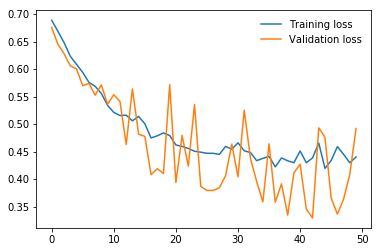

In [13]:
# Plot training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [14]:
# predict test data:
accuracy = 0
with torch.no_grad():    
    for i, (items, classes) in enumerate(test_loader):
        outputs = net(items)
        
        ps = torch.exp(outputs)

        top_p, top_class = ps.topk(1, dim=1)
        labels = classes.view(*top_class.shape)

        equals = top_class == labels
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
print(f'Accuracy: {accuracy/len(test_loader)*100}%')
print(f'Predicted Outcome:{top_class.view(*classes.shape)}')
print(f'Actual Outcome:{classes}')      

Accuracy: 86.0%
Predicted Outcome:tensor([0, 0, 1, 1])
Actual Outcome:tensor([0, 0, 1, 1])
